In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
!pip -q install transformers
!pip -q install pytorch_ranger
!pip -q install contractions

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [36]:
import os
import re
import time
import copy
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from pytorch_ranger import Ranger
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import contractions
from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup

In [4]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.backends.cudnn.deterministic = True
        torch.cuda.manual_seed(seed)

seed_everything(42)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [6]:
data = pd.read_csv('../input/nlp-getting-started/train.csv')
test_df = pd.read_csv('../input/nlp-getting-started/test.csv')
sample_df = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
ids_with_target_error = [328,443,513,2619,3640,3900,4342,5781,6552,6554,6570,6701,6702,6729,6861,7226]
data.loc[data['id'].isin(ids_with_target_error),'target'] = 0
data.drop(columns=['keyword', 'location', 'id'], inplace=True)
data.rename(columns={'target':'labels'}, inplace=True)
data.head()

,text,labels
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
train_df, val_df = train_test_split(data, test_size=0.2, random_state=42)
print('Train Samples: ', len(train_df), 'Validation Samples: ', len(val_df), 'Test Samples: ', len(test_df))

Train Samples:  6090 Validation Samples:  1523 Test Samples:  3263


In [9]:
model_type = 'bert-large-uncased'
tokenizer = BertTokenizer.from_pretrained(model_type)

In [10]:
def text_preprocessing(txt):
    
    txt = txt.lower()                                # Converting text to lowercase
    txt = contractions.fix(txt)                      # Expanding Contractions
    txt = re.sub(r'(@.*?)[\s]', ' ', txt)            # Replacing @names by space
    txt = re.sub(r'([\;\:\|•«\n])', ' ', txt)        # Replacing special characters by space
    txt = re.sub(r'\s+', ' ', txt)                   # Removing trailing Spaces
    txt = re.sub(r"https?://\S+|www\.\S+",'', txt)   # Removing hyperlinks
    txt = re.sub(r'[^\x00-\x7f]','', txt)           # Removing non-ASCII characters
    
    return txt

In [11]:
class classification_dataset(Dataset):
    def __init__(self, df, phase, tokenizer, labels=None, max_len=512):
        self.df = df
        self.phase = phase
        self.tokenizer = tokenizer
        self.labels = labels
        self.max_len = max_len
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, item):
        text = str(self.df.text.to_numpy()[item])
        preprocessed_text = text_preprocessing(text)
        encoding = self.tokenizer.encode_plus(text, add_special_tokens=True, max_length=self.max_len,
                                    pad_to_max_length=True, truncation=True, 
                                return_attention_mask=True, return_token_type_ids=False, return_tensors='pt')
        if self.phase=='test':
            return {'input_ids':encoding['input_ids'].flatten(),
                   'attention_mask':encoding['attention_mask'].flatten()}
        else:
            return {'input_ids':encoding['input_ids'].flatten(),
                   'attention_mask':encoding['attention_mask'].flatten(),
                   'labels':torch.tensor(self.labels.to_numpy()[item], dtype=torch.long)}

In [12]:
def plot_results(results):
    for i in range(len(results)):
        fig, ax = plt.subplots(3,2,figsize=(20,15))
        num_epochs = [i for i in range(1,5)]
        rates = results[i].results["train"].learning_rate
        f1_score = results[i].results["train"].f1_score
        precision = results[i].results["train"].precision
        recall = results[i].results["train"].recall

        train_losses = results[i].results["train"].losses
        eval_losses = results[i].results["eval"].losses

        train_epoch_losses = results[i].results["train"].epoch_loss
        eval_epoch_losses = results[i].results["eval"].epoch_loss
        train_epoch_acc = results[i].results["train"].epoch_accuracy
        val_epoch_acc = results[i].results["eval"].epoch_accuracy

        ax[0,0].plot(f1_score, '.-', c="maroon", label="f1-score")
        ax[0,0].plot(precision, '.-', c="salmon", label="precision")
        ax[0,0].plot(recall, '.-', c="lightsalmon", label="recall")

        ax[0,0].legend();
        ax[0,0].set_xlabel("Iterations")
        ax[0,0].set_ylabel("Score values")
        ax[0,0].set_title("Evaluation scores for learning rate search within {} epochs".format(5));

        ax[0,1].plot(rates)
        ax[0,1].set_ylabel("Learning rates")
        ax[0,1].set_xlabel("Iterations")
        ax[0,1].set_title("Learning rates")

        ax[1,0].plot(train_losses, label="train")  
        ax[1,0].set_xlabel("Iterations")
        ax[1,0].set_ylabel("Loss")
        ax[1,0].legend()
        ax[1,0].set_title("Running Losses")

        ax[1,1].plot(eval_losses, label="eval")
        ax[1,1].set_xlabel("Iterations")
        ax[1,1].set_ylabel("Loss")
        ax[1,1].legend()
        ax[1,1].set_title("Running Losses")

        ax[2,1].plot(train_epoch_losses, label="train")
        ax[2,1].plot(eval_epoch_losses, label="eval")
        ax[2,1].set_title("Epoch losses")
        ax[2,1].legend()

        ax[2,0].plot(train_epoch_acc, label="train")
        ax[2,0].plot(val_epoch_acc, label="eval")
        ax[2,0].set_title("Epoch Accuracy")
        ax[2,0].legend()

In [13]:
BATCH_SIZE = 8
# Loading Training Data
train_set = classification_dataset(train_df, 'train', tokenizer, train_df.labels, 94)
train_loader = DataLoader(train_set, shuffle=True, batch_size=BATCH_SIZE)

# Loading Validation Data
val_set = classification_dataset(val_df, 'val', tokenizer, val_df.labels, 94)
val_loader = DataLoader(val_set, shuffle=True, batch_size=BATCH_SIZE)

In [14]:
class build_model(torch.nn.Module):
    
    def __init__(self, num_classes):
        super(build_model, self).__init__()
        self.baseline = BertModel.from_pretrained(model_type)
        self.drop = nn.Dropout(p=0.2)
        self.classifier = nn.Sequential(nn.Linear(self.baseline.config.hidden_size, num_classes),
                                   nn.Softmax(dim=1))

    def forward(self, input_id, attention_mask):
        _, pooled_output = self.baseline(input_ids=input_id, attention_mask=attention_mask)
        x = self.drop(pooled_output)
        output = self.classifier(x)
        return output

In [37]:
def start_training(dataloaders_dict, num_epoch, criterion, patience, results, resume_training=False, save_model=False, find_lr=False):
    
    start_train = time.time()
    stop_training = False
    if find_lr:
        phases = ['train']
    else:
        phases = ['train', 'eval']
    if resume_training:
        checkpoint = torch.load('./model.pth')
        results.model.state_dict(checkpoint['state_dict'])
    best_acc = 0
    patience_count = 0
    
    for epoch in range(1, num_epoch+1):
        if stop_training:
            break
        print(f'Starting Epoch: {epoch} of {num_epoch}')
        description = 'Training...'
        
        for phase in phases:
            start_phase = time.time()
            dataloader = dataloaders_dict[phase]
            dl_iter = tqdm(dataloader, desc=description, total=len(dataloader))
            
            if phase=='train':
                results.model.train()
            else:
                results.model.eval()
            
            all_preds = np.zeros(len(dataloader)*dataloader.batch_size)
            all_target = np.zeros(len(dataloader)*dataloader.batch_size)
            running_loss = 0
            running_true_positives = 0
            running_false_positives = 0
            running_false_negatives = 0
            for counter, data in enumerate(dl_iter):
                input_ids = data['input_ids']
                input_masks = data['attention_mask']
                label = data['labels']

                input_ids = input_ids.to(device, dtype=torch.long)
                input_masks = input_masks.to(device, dtype=torch.float)
                label = label.to(device, dtype=torch.float32)
                results.optimizer.zero_grad()
                output = results.model(input_ids, input_masks)
                _, pred = torch.max(output, 1)
                
                running_true_positives += ((pred*label)/len(label)).sum().cpu().detach().numpy()
                running_false_positives += ((pred*(1-label))/len(label)).sum().cpu().detach().numpy()
                running_false_negatives += (((1-pred)*label)/len(label)).sum().cpu().detach().numpy()
                
                precision = running_true_positives/(running_true_positives + running_false_positives+1e-7)
                recall = running_true_positives/(running_true_positives + running_false_negatives+1e-7)
                f1_score = 2*precision*recall/(precision+recall+1e-7)
                
                results.results[phase].learning_rate.append(optimizer.state_dict()['param_groups'][0]['lr'])
                results.results[phase].precision.append(precision)
                results.results[phase].recall.append(recall)
                results.results[phase].f1_score.append(f1_score)
                
                batch_size = dataloader.batch_size
                if pred.shape[0] != batch_size:
                    all_preds[(counter*batch_size):(counter*batch_size)+pred.shape[0]] = pred.cpu().detach().numpy()
                    all_target[(counter*batch_size):(counter*batch_size)+pred.shape[0]] = label.cpu().detach().numpy()
                else:
                    all_preds[(counter*batch_size):(counter+1)*batch_size] = pred.cpu().detach().numpy()
                    all_target[(counter*batch_size):(counter+1)*batch_size] = label.cpu().detach().numpy()
                cat_tensor = torch.cat((label,torch.tensor(results.classes, device=device)),0)
                dummy_labels = pd.get_dummies(cat_tensor.cpu().detach())
                drop_idx = []
                for i in range(len(results.classes)):
                    drop_idx.append(len(dummy_labels)-i-1)
                dummy_labels = dummy_labels.drop(index=drop_idx).to_numpy()
                label = torch.tensor(dummy_labels, dtype=torch.float32, device=device)

                loss = criterion(output, label)
                running_loss += loss.item()*batch_size
                overall_loss = running_loss/((counter+1)*batch_size)
                results.results[phase].losses.append(overall_loss)
                dl_iter.set_postfix(loss=overall_loss)
                if phase=='train':
                    loss.backward()
                    nn.utils.clip_grad_norm_(results.model.parameters(), max_norm=1.0)
                    results.optimizer.step()
                    if results.scheduler is not None:
                        results.scheduler.step()
                
            accuracy = accuracy_score(all_target, all_preds)
            results.results[phase].epoch_accuracy.append(accuracy)
                
            epoch_loss = running_loss/len(dataloader.dataset)
            results.results[phase].epoch_loss.append(epoch_loss)
            description = 'Validating...'  
            print(f'Epoch: {epoch} \t Phase: {phase} \t Epoch Loss: {epoch_loss:.4f} \t Epoch Accuracy: {accuracy:.4f}')
            
            if not find_lr:
                if phase=='eval':
                    if accuracy > best_acc and save_model:
                        best_acc = accuracy
                        best_model = copy.deepcopy(results.model.state_dict())
                        best_optimizer = copy.deepcopy(results.optimizer.state_dict())
                        if results.scheduler is not None:
                            best_scheduler = copy.deepcopy(results.scheduler.state_dict())
                        best_epoch = epoch
                        best_loss = overall_loss
                    else:
                        patience_count += 1
                        if patience_count==patience:
                            print(f"Early Stopping Training at epoch {epoch} because Model isn't improving.")
                            stop_training=True
            print('*'*100)
    if not find_lr and save_model:
        results.model.load_state_dict(best_model)
        results.optimizer.load_state_dict(best_optimizer)
        if results.scheduler is not None:
            results.scheduler.load_state_dict(best_scheduler)
        results.best_epoch = best_epoch
        results.best_loss = best_loss
        torch.save(results.model.state_dict(), './model.pth')
    time_taken = time.time() - start_train
    print(f'Training finished in: {time_taken//60}m {time_taken%60:.2f}s')
    return results

In [38]:
class logs:
    
    def __init__(self):
        
        self.precision = []
        self.recall = []
        self.f1_score = []
        self.losses = []
        self.learning_rate = []
        self.epoch_accuracy = []
        self.epoch_loss = []

class Results:
    
    def __init__(self, model, optimizer, classes, scheduler=None):
        
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.classes = classes
        self.best_loss = 0
        self.best_epoch = 0
        self.train_logs = logs()
        self.val_logs = logs()
        self.results = {'train': self.train_logs, 'eval': self.val_logs}

In [39]:
def train(model, criterion, optimizer, num_epoch, dataloader_dict, classes=[0,1],
          patience=1, scheduler=None, resume_training=False, save_model=False, find_lr=False):
    
    results = Results(model, optimizer, classes, scheduler)
    train_results = start_training(dataloader_dict, num_epoch, criterion, patience, results, resume_training, save_model, find_lr)
    
    return train_results

In [40]:
results = {}
dl_dict = {'train':train_loader, 'eval': val_loader}
learning_rates = [3e-5]
for i,lr in enumerate(learning_rates):
    my_model = build_model(num_classes=2)
    my_model = my_model.to(device)
    criterion = torch.nn.BCELoss()
    optimizer = Ranger(my_model.parameters(), lr=lr, weight_decay=0.01)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader)*4)
    results[i] = train(my_model, criterion, optimizer, 4, dl_dict, patience=5,
                       scheduler=scheduler, resume_training=False, save_model=False, find_lr=False)

Starting Epoch: 1 of 4


/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,



Epoch: 1 	 Phase: train 	 Epoch Loss: 0.5195 	 Epoch Accuracy: 0.7557
****************************************************************************************************



Epoch: 1 	 Phase: eval 	 Epoch Loss: 0.3948 	 Epoch Accuracy: 0.8429
****************************************************************************************************
Starting Epoch: 2 of 4



Epoch: 2 	 Phase: train 	 Epoch Loss: 0.3803 	 Epoch Accuracy: 0.8545
****************************************************************************************************



Epoch: 2 	 Phase: eval 	 Epoch Loss: 0.4559 	 Epoch Accuracy: 0.8377
****************************************************************************************************
Starting Epoch: 3 of 4



Epoch: 3 	 Phase: train 	 Epoch Loss: 0.3301 	 Epoch Accuracy: 0.8927
****************************************************************************************************



Epoch: 3 	 Phase: eval 	 Epoch Loss: 0.5444 	 Epoch Accuracy: 0.8410
****************************************************************************************************
Starting Epoch: 4 of 4



Epoch: 4 	 Phase: train 	 Epoch Loss: 0.2683 	 Epoch Accuracy: 0.9221
****************************************************************************************************



Epoch: 4 	 Phase: eval 	 Epoch Loss: 0.6515 	 Epoch Accuracy: 0.8436
****************************************************************************************************
Training finished in: 19.0m 31.79s


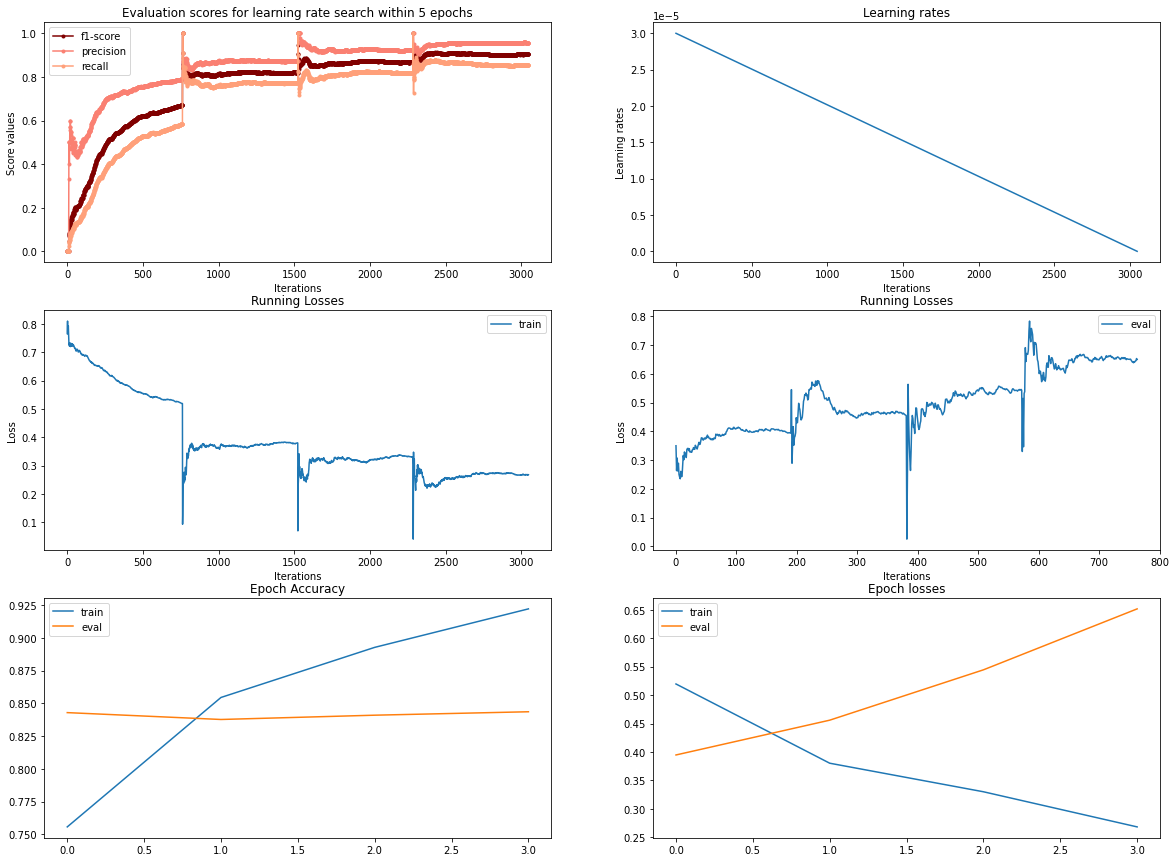

In [41]:
plot_results(results)

In [42]:
def inference(results, dataloader, tta=1):
    final_pred = np.zeros(len(dataloader)*dataloader.batch_size-1)
    tta_iter = tqdm(range(1, tta+1), desc='TTA: ', total=tta, position=0)
    for aug in tta_iter:
        print(f'TTA phase: {aug} of {tta}')
        dl_iter = tqdm(dataloader, desc='Processing...', total=len(dataloader))
        with torch.no_grad():
            for counter, data in enumerate(dl_iter):
                input_ids = data['input_ids']
                input_ids = input_ids.to(device, dtype=torch.long)
                attention_mask = data['attention_mask']
                attention_mask = attention_mask.to(device, dtype=torch.float)

                output = results.model(input_ids, attention_mask)
                _, pred = torch.max(output, 1)
                batch_size = dataloader.batch_size
                if pred.shape[0] != batch_size:
                    final_pred[(counter*batch_size):(counter*batch_size)+pred.shape[0]] += pred.cpu().detach().numpy()/tta
                else:
                    final_pred[(counter*batch_size):(counter+1)*batch_size] += pred.cpu().detach().numpy()/tta
    return final_pred

In [43]:
# Loading Test Data
test_set = classification_dataset(test_df, 'test', tokenizer, val_df.labels, 94)
test_loader = DataLoader(test_set, shuffle=False, batch_size=2*BATCH_SIZE)

In [ ]:
predictions = inference(results[0], test_loader, 3)

TTA phase: 1 of 3


In [ ]:
sample_df.target=predictions
sample_df['target'] = [int(i>0.5) for i in sample_df.target.values]
sample_df

In [32]:
sample_df.to_csv('final_sub.csv', index=False)